# Measurement of the D Meson mass

In this exercise we apply our knowledge to a real-world problem, or rather to a high energy physics problem.
We want to increase the signal-to-noise ratio of a sample of "D mesons" in order to extract their mass more precisely.

We will use **sklearn** in this exercise, but you can also use TMVA if you have an appropriate environment (like swan) to run the notebook (see 2_tmva.ipynb)

We use a dataset from the Belle experiment. The Belle experiment was located in Tsukuba, Japan at the KEKB asymmetric electron-positron collider, which operated at a center of mass energy of 10.58 GeV.
The decay D0 -> K- pi+ (pi0 -> gamma gamma) was reconstructed and simple cuts on the particle identification information and the kinematics were applied to reduce the combinatorical background.
A mass-constrained vertex fit of the pi0 was performed, and an unconstrained vertex fit of the D0.

Two datasets are provided:
 * csc_mc.npy (or csc_mc.root) contains Monte Carlo simulated events
 * csc_data.npy (or csc_data.root) contains Detector Data
 
**Execute the following cell to download the data (you only have to do this once)**

In [6]:
#! rm csc_mc.root csc_data.root
#! wget http://ekpwww.ekp.kit.edu/~tkeck/csc_mc.root http://ekpwww.ekp.kit.edu/~tkeck/csc_data.root
! rm csc_mc.npy csc_data.npy
! wget http://ekpwww.ekp.kit.edu/~tkeck/csc_mc.npy http://ekpwww.ekp.kit.edu/~tkeck/csc_data.npy

rm: das Entfernen von 'csc_mc.npy' ist nicht möglich: Datei oder Verzeichnis nicht gefunden
rm: das Entfernen von 'csc_data.npy' ist nicht möglich: Datei oder Verzeichnis nicht gefunden
--2017-09-18 21:15:33--  http://ekpwww.ekp.kit.edu/~tkeck/csc_mc.npy
Auflösen des Hostnamens »ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)« … 129.13.101.178
Verbindungsaufbau zu ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)|129.13.101.178|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 52876732 (50M)
Wird in »»csc_mc.npy«« gespeichert.

csc_mc.npy          100%[===================>]  50,43M   702KB/s    in 74s     

2017-09-18 21:16:46 (702 KB/s) - »»csc_mc.npy«« gespeichert [52876732/52876732]

--2017-09-18 21:16:46--  http://ekpwww.ekp.kit.edu/~tkeck/csc_data.npy
Wiederverwendung der bestehenden Verbindung zu ekpwww.ekp.kit.edu:80.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 46164912 (44M)
Wird in »»csc_data.npy«« gespeichert.

csc_data.npy        10

## The SciPy stack

**Python-based ecosystem of open-source software for mathematics, science, and engineering**

 * **NumPy** N-dimensional array package and data format used in SciPy
 * **Matplotlib** Plotting and data visualization
 * **SciPy** Scientific computing: Integration, Optimization, Statistics, ...
 * **SKLearn** Simple and efficient tools for data mining and data analysis
 * **Pandas** Data structures & data analysis
 
You can find out more here https://www.scipy.org/

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

# Ignore this if you are not a HEP physicist

### Convert ROOT to a numpy.ndarray or pandas.DataFrame
Converting your ROOT file to a pandas.DataFrame (and vice versa) is easy.
You can use the **root_numpy** package. You can also directly convert it to a pandas.DataFrame using the **root_pandas** package. 

In [7]:
#import root_numpy
#mc = pd.DataFrame.from_records(root_numpy.root2array('csc_mc.root'))
#data = pd.DataFrame.from_records(root_numpy.root2array('csc_data.root'))

## Reading in the data and converting them to a pandas.DataFrame

Reading in our data is easy, we use the np.load function here.
I saved the data using np.save earlier

In [16]:
mc = np.load('csc_mc.npy')
data = np.load('csc_data.npy')

Usually it is more convenient to use pandas.DataFrame instead of a plain numpy array.

In [17]:
mc = pd.DataFrame.from_records(mc)
data = pd.DataFrame.from_records(data)

Next we shuffle the mc data and split it into a train and an independent test dataset,
which we will use to evaluate the performance of our classifier before we apply it to detector data

In [18]:
mc = mc.sample(frac=1)
train, test = mc[:len(mc)//2], mc[len(mc)//2:]

## Detailed Description of all Features

The overall signal fraction in the provided sample is 2.9%.
Signal (correctly reconstructed D0 candidates) and background candidates (combinatorical background and background
from other decays) can be distinguished by the **isSignal** feature, where 1 indicates signal and 0 indicates background.


The following additional features are provided:

- **index** index (number from 0 to ~200 000)
- **Kinmeatic features of the D0**
    * **p** total momentum
    * **pt** transverse momentum = sqrt(px*px+py*py)
    * **pz** z component of the momentum
    * **phi** angle between the pt and the x-axis
    * **M** invariant mass
- **Vertex fit features of the D0**
    * **chiProb** p-value of the decay vertex fit
    * **dr** fitted transverse distance of the decay vertex
    * **dz** fitted distance in z of the decay certex
    * **dphi** angle between dr and the x-axis
- **Pairwise quantities of the daughters**
    * **daughterAngleIJ** angle between the momentum of the Ith and Jth daughter, where I,J in {0,1,2}
    * **invariantMassIJ** pairwise invariant mass of the Ith and Jth daughter, where I,J in {0,1,2}
- **Kinematic features of the daughters**
    * **pI** total momentum of the Ith daughter, where I in {0,1,2}
    * **ptI** transverse momentum of the Ith daughter, where I in {0,1,2}
    * **pzI** z component of the momentum of the Ith daughter, where I in {0,1,2}
    * **phiI** angle between the pt and the x-axis of the Ith daughter, where I in {0,1,2}
- **Track fit features of the daughters**
    * **chiProbI** p-value of the track fit of the Ith daughter, where I in {0,1}
    * **drI** fitted transverse distance of the POCA of the Ith daughter, where I in {0,1}
    * **dzI** fitted distance in z to the POCA of the Ith daughter, where I in {0,1}
    * **dphiI** angle between dr and the x-axis of the Ith daughter, where I in {0,1}
- **Particle identification information**
    * **KidI** kaon likelihood of the Ith daughter, where I in {0,1}
    * **piidI** pion likelihood of the Ith daughter, where I in {0,1}
- **Information about the photons used for the pi0**
    * **M2** the invariant mass of the two photons
    * **chiProb2** p-value of the mass-constrained vertex fit
    * **EI** Energy of the Ith photon, where I in {0,1}
    * **highestEI** The hit with the highest Energy of the Ith photon, where I in {0,1}
    * **hitsI** The number of hits of the Ith photon in the ECK, where I in {0,1}
    * **ratioI** ratio between the 9 cells and 25 cells around the seed of the photon cluster, for the Ith photon, where I in {0,1}
  * **distanceI** distance of the cluster to the closest track in the CDC of the Ith photon, where I in {0,1}


All momenta and energies are given in **GEV**, and all distances in **cm**.

### Glossary

 * **POCA** point of closest approach to the beam axis
 * **CDC** central drift chamber


## Getting an Overview over the data
Understanding the data is usually an important and time-consuming step during data analysis. Detecting errors due to data collection, preprocessing the data to cast it in a usable format for the task at hand, check for differences between simulated and real data, choosing sensible pre-cuts to minimize the required computing resources and systematic uncertainties. We will keep this part very short here.

In general **you should only use features in your multivariate classifer which**:
  - You understand well
  - That do NOT contain MC information (physics) or future information (industry)
  
In additional for many classifiers it is useful to choose the features to be:
  - correlated to your target
  - and uncorrelated to each other.

In the next cell you see a simple plotting function, which you can use if you are not familiar with the SciPy stack

In [19]:
def simple_plot(variable, mc=mc, data=data, normed=False):
    config = dict(bins=50, normed=normed)
    data[variable].hist(label='Data', color='grey', **config)
    config.update(lw=2, histtype='step')
    mask = mc['isSignal'] == 1
    mc.loc[mask, variable].hist(label='Monte Carlo (Signal)', color='red', weights=mc.loc[mask, 'w'],  **config)
    mc.loc[~mask, variable].hist(label='Monte Carlo (Background)', color='blue', weights=mc.loc[~mask, 'w'], **config)
    plt.ylabel('Normalised number of events')
    plt.xlabel(variable)
    plt.legend(bbox_to_anchor=(0.9, 1.35))
    plt.show()

** Invariant Mass of the D0 mesons **

The filled grey histogram shows the data, the expectation from Monte Carlo simulation is shown in red for signal and blue for background. You can clearly see that the Monte Carlo simulation predicted too much background.

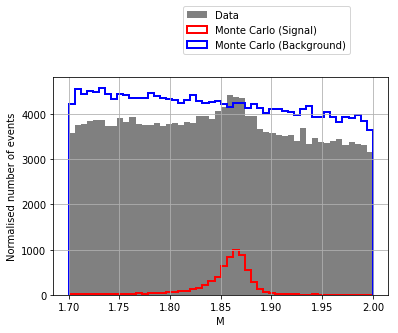

In [20]:
simple_plot('M')

### Exercise 1

Look at the distributions for some of the variables and familiarize yourself with the dataset.
You can use the provided simple_plot function and the names of the features described above e.g.
p1 for the total momentum of the Kaon, invariantMass01 for the invariant mass of the Kaon-pion system, chiProb2 for the chi2 probability of the mass-constrained vertex fit of the pi0.

In [6]:
# Your plotting code goes here

## SKLearn

Scikit-Learn (aka SKlearn) is a machine learning library build on top of the scipy project, which aims to provide a full data analysis stack for science written in python. Hence SKLearn integrates well with famous python libraries like numpy, pandas and matplotlib. You can find more information on these frameworks here http://scikit-learn.org and here https://www.scipy.org.

We train a few of the methods we discussed in the lecture. Our goal is to improve the signal-to-noise ratio in our data.
You can use the evaluate_classifier function to judge the performance of the classifier if you are not familiar
with the SciPy stack, or write your own evaluation function.
The function plots the ROC curve and the invariant mass distribution with the maximal signal-to-noise ratio.

In [212]:
features = ['p', 'pt', 'pz', 'phi', 'chiProb', 'dr', 'dz', 'dphi', # D0
            'Kid0', 'chiProb0', 'dr0', 'dz0', # K-
            'Kid1', 'chiProb1', 'dr1', 'dz1', # pi+
            # Kinematic quantities of the daughters (WARNING This can be problematic see exercise 2.4)
            "p0", "p1", "p2", "daughterAngle01", "daughterAngle02",  
            "pt0", "pt1", "pt2", "pz0", "pz1", "pz2", "phi0", "phi1", "phi2", "invariantMass01", "invariantMass02",
            'E0', 'width0', 'highestE0', 'hits0', 'ratio0', 'distance0', # first gamma
            'E1', 'width1', 'highestE1', 'hits1', 'ratio1', 'distance1', # second gamma
            'chiProb2' # pi0
           ]
target = ['isSignal']

import sklearn.metrics
import scipy.optimize

def signal_to_noise(cut, p, df):
    "Calculates the signal-to-noise ratio for a given cut on the probability p for the dataset df"
    s = df[(p > cut[0]) & (df.M > 1.8) & (df.M < 1.9)]
    return -s.loc[s.isSignal == 1, 'w'].sum() / (s['w'].sum()**0.5 + 0.001)

def plot_fom(clf, train=train, test=test):
    p_train = clf.predict_proba(train[features])[:, 1]
    p_test = clf.predict_proba(test[features])[:, 1]
    x = np.linspace(0.00, 1.0, 100)
    plt.plot(x, [-signal_to_noise([i], p_train, train) for i in x], label='Train')
    plt.plot(x, [-signal_to_noise([i], p_test, test) for i in x], label='Test')
    plt.xlabel('cut on the classifier output')
    plt.ylabel('signal to noise ratio')
    plt.legend()
    plt.show()

def evaluate_classifier(clf, train=train, test=test, data=data, cut=None):
    """
    Evaluates the classifier by plotting roc curves and 
    the optimal signal-to-noise ratio on data which can be achieved using this classifier
    @param clf an sklearn classifier
    @param train the training mc dataset
    @param test the independent test mc dataset
    @param data the dataset containing the recorded data from the detector
    @param cut set the final cut by hand instead of using the optimization
    @return the signal-to-noise ratio before and after the cut.
    """
    p_train = clf.predict_proba(train[features])[:, 1]
    p_test = clf.predict_proba(test[features])[:, 1]
    p_data = clf.predict_proba(data[features])[:, 1]
    plt.plot([0,1], [0,1], 'k--', color='black')
    fpr, tpr, _ = sklearn.metrics.roc_curve(train[target], p_train, sample_weight=train['w'])
    auc = sklearn.metrics.roc_auc_score(train[target], p_train, sample_weight=train['w'])
    plt.plot(fpr, tpr, color='blue', label='Train (AUC = {:.2f})'.format(auc))
    fpr, tpr, _ = sklearn.metrics.roc_curve(test[target], p_test, sample_weight=test['w'])   
    auc = sklearn.metrics.roc_auc_score(test[target], p_test, sample_weight=test['w'])
    plt.plot(fpr, tpr, color='green', label='Test (AUC = {:.2f})'.format(auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    if cut is None:
        cut = scipy.optimize.minimize(signal_to_noise, [p_train.mean()], args=(p_train, train)).x[0]
    simple_plot('M', mc=pd.concat([train[p_train > cut], test[p_test > cut]]), data=data[p_data > cut])
    return("Signal To Noise before {:.2f} and after {:.2f}".format(-signal_to_noise([0.0], p_train, train),
                                                  -signal_to_noise([cut], p_train, train)))

## Linear Discriminant Analysis

Using a very simple method as a baseline to get your data analysis pipeline up and running is best-practice in data-science. LDA is a good starting point. If your later models fail to reach the performance of LDA you can be pretty sure that you still have to fix some bugs :-)

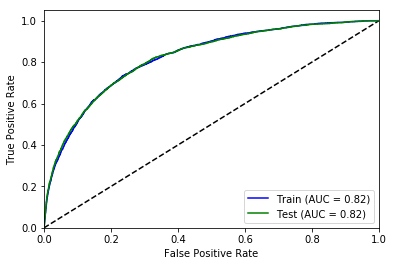

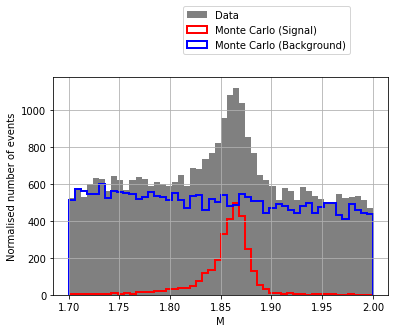

'Signal To Noise before 12.79 and after 18.47'

In [204]:
import sklearn.discriminant_analysis
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(train[features], train[target].values.ravel())
evaluate_classifier(lda)

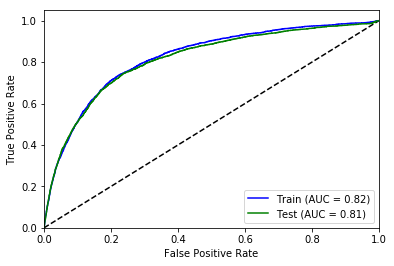

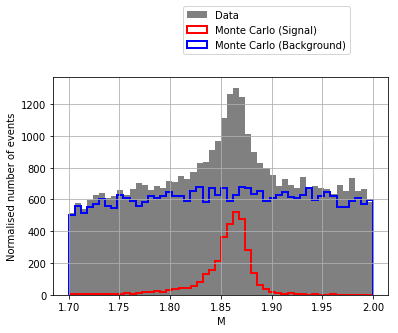

'Signal To Noise before 12.79 and after 18.56'

In [198]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(train[features], train[target].values.ravel())
evaluate_classifier(qda)

## Boosted Decision Tree

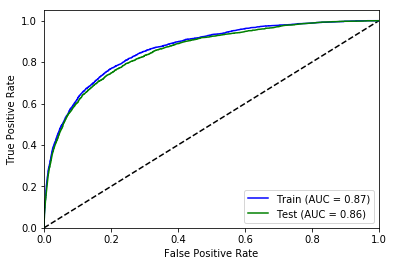

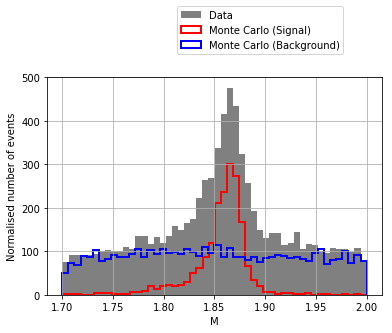

'Signal To Noise before 12.79 and after 21.54'

In [154]:
import sklearn.ensemble
bdt = sklearn.ensemble.GradientBoostingClassifier(n_estimators=30)
bdt.fit(train[features], train[target].values.ravel())
evaluate_classifier(bdt)

## Exercise 2

### 2.1

Which method is the best? Are the methods overfitted?

### 2.3

Try to optimize the hyper-parameters of three simple methods shown above.
You can get an overview of the available parameters of each classifier by executing 

> lda?
>
> qda?
>
> bdt?


### 2.3

Use the artificial neural network from Exercise 1 to solve the tasks.

### 2.4 (for HEP physicists)

Using the kinematic quantities as features which allow to infer the invariant mass can be problematic.
Why? Hint: Add the invariant mass itself to the features.
Which method is more prone to this problem BDTs or neural networks. Why?

## Data driven techniques

The following exercise requires knowledge about HEP and machine learning.
It is meant for students which prior knowledge in machine learning.


### Correcting for Data / MC differences

It is possible to correct differences in the data and MC using multivariate classifiers.
You train a classifer, which distinguishes data and MC.
The output of the classifier can be interpreted as the probability of a event to be "data" if drawn from a ensemble "data + mc": $p = \frac{data}{data + mc}$
Next you can assign each Monte Carlo event a probability to be data: $w = \frac{data}{mc}$.
If you use w as a weight in a training signal against background you effectively corrected for all differences between data and MC the classifier is able to distinguish.

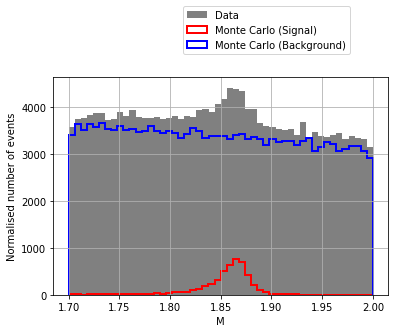

In [155]:
reweight = sklearn.ensemble.GradientBoostingClassifier(n_estimators=30)
reweight.fit(pd.concat([mc[features], data[features]]), np.r_[np.zeros(len(mc)), np.ones(len(data))])
p = reweight.predict_proba(mc[features])[:, 1]
mc['w'] = p / (1-p)
train, test = mc[len(mc)//2:], mc[:len(mc)//2]
simple_plot('M')

Now we train our BDT as usual, but we use the weights we calculated from the data vs MC BDT output!

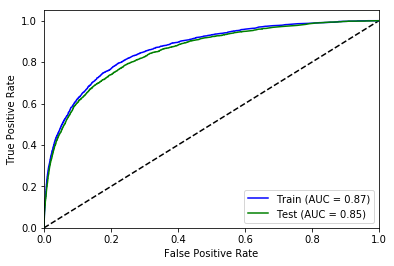

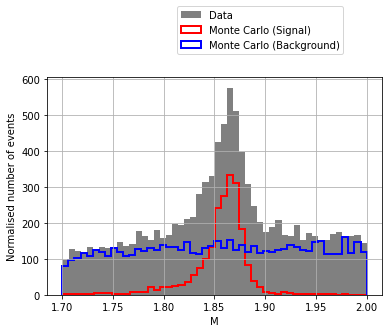

'Signal To Noise before 12.79 and after 21.75'

In [156]:
clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=30)
clf.fit(train[features], train[target].values.ravel(), sample_weight=train['w'])
evaluate_classifier(clf)

## Exercise 3

### 3.1

Is the performance of the classifier with reweighting better? Why (not)?

## Sideband Subtraction

It is possible to train a multivariate classifier on data only.
You can do so by defining three distinct regions in your phase-space:
 * a **signal-enriched region**
 * and two **signal-free regions** called **background region** and **negative signal region**.
Now you train a classifier using
 - all events from the **signal-enriched region** as signal with weight 1 (yes this does also include background events!)
 - all events from the first **signal-free region** (the **background region**) as background with weight 1
 - all events from the second **signal-free region** (the **negative signal region**) as signal with weight -1
The events background events from the negative signal region will statistically counteract the background events within the signal region, effectively your classifier is trained on signal vs. background.

**You only have to ensure that the amount of events in the negative signal region is the same as the amount of background events you expect in the signal region.** (Of course, you can also just reweight the events accordingly)

IMPORTANT: Sideband Subtraction assumes that it is not possible to infern the region using the provided features!
Hence, you must remove the daughter kinematics from the feature list above.

In [157]:
signal_enriched_region = (mc['M'] > 1.8301627) & (mc['M'] < 1.89)
signal_enriched_sample = mc[signal_enriched_region]
print("#Signal", signal_enriched_sample['isSignal'].sum())
print("#Bckgrd", (1-signal_enriched_sample['isSignal']).sum())

#Signal 5226.0
#Bckgrd 42100.0


In [158]:
background_region = (mc['M'] < 1.72) | (mc['M'] > 1.98)
background_sample = mc[background_region]
print("#Signal", background_sample['isSignal'].sum())
print("#Bckgrd", (1-background_sample['isSignal']).sum())

#Signal 32.0
#Bckgrd 27476.0


In [159]:
negative_signal_region = ((mc['M'] < 1.7501) | (mc['M'] > 1.95)) & ~background_region
negative_signal_sample = mc[negative_signal_region]
print("#Signal", negative_signal_sample['isSignal'].sum())
print("#Bckgrd", (1-negative_signal_sample['isSignal']).sum())

#Signal 79.0
#Bckgrd 42100.0


In [169]:
sideband_X = pd.concat([signal_enriched_sample[features],
                        background_sample[features],
                        negative_signal_sample[features]])
sideband_y = np.r_[np.ones(len(signal_enriched_sample)),        # Signal
                   np.zeros(len(background_sample)),            # Background
                   np.ones(len(negative_signal_sample))]        # Signal
sideband_weights=np.r_[np.ones(len(signal_enriched_sample)),    # Weight  1
                       np.ones(len(background_sample)),         # Weight  1
                       -np.ones(len(negative_signal_sample))]   # Weight -1

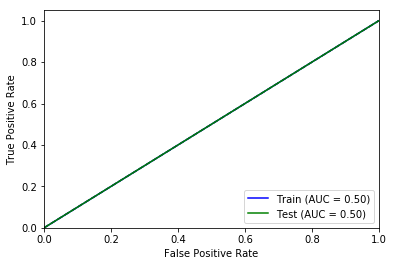

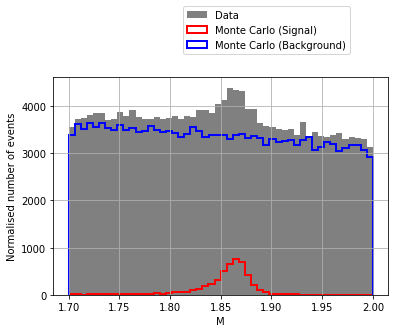

'Signal To Noise before 12.78 and after 12.78'

In [170]:
sideband_clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=30)
sideband_clf.fit(sideband_X, sideband_y, sample_weight=sideband_weights)
evaluate_classifier(sideband_clf)

## Exercise 4

### 3.1

Did it work? Why (not)? Hint: Read the documentation of sklearn.ensemble.GradientBoostingClassifier?

## Sideband Subtraction 2

Unfortunately sklearn support for negative and even weights in general is not that good.
Hence we are forced to use another implementation. This is the point where you want
to switch to xgboost or tensorflow (or TMVA...)

In [171]:
import xgboost as xgb

class XGBoostWrapper():
    def __init__(self, ntrees=100, parameters={}):
        self.parameters = {'bst:max_depth': 3, 'bst:eta': 1, 'silent': 0, 'objective': 'binary:logistic'}
        self.parameters.update(parameters)
        self.ntrees = ntrees
        
    def fit(self, X, y, w=None):
        dtrain = xgb.DMatrix(X, label=y.astype(int), weight=w)
        self.bdt = xgb.train(self.parameters, dtrain, self.ntrees, [(dtrain, 'train')])

    def predict_proba(self, X):
        data = xgb.DMatrix(X)
        r = self.bdt.predict(data)
        return np.c_[1-r, r]

[0]	train-error:0.027863
[1]	train-error:0.027854
[2]	train-error:0.027688
[3]	train-error:0.027743
[4]	train-error:0.027817
[5]	train-error:0.027706
[6]	train-error:0.027752
[7]	train-error:0.02778
[8]	train-error:0.027697
[9]	train-error:0.02766


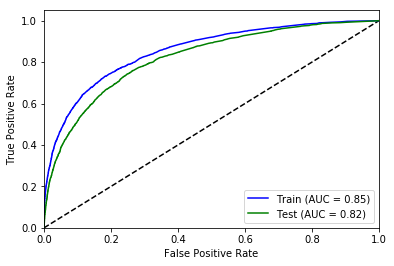

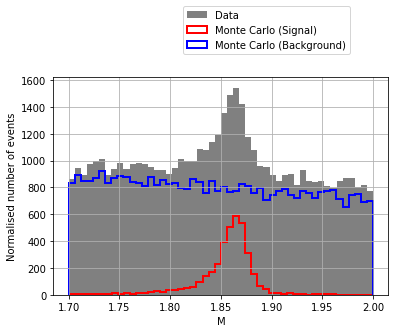

'Signal To Noise before 12.79 and after 18.99'

In [205]:
bdt = XGBoostWrapper(ntrees=10)
bdt.fit(train[features], train[target].values.ravel())
evaluate_classifier(bdt)

[0]	train-error:0.826091
[1]	train-error:0.827316
[2]	train-error:0.828939
[3]	train-error:0.827775
[4]	train-error:0.827408
[5]	train-error:0.82753
[6]	train-error:0.82704
[7]	train-error:0.825295
[8]	train-error:0.82358
[9]	train-error:0.819017
[10]	train-error:0.817608
[11]	train-error:0.814454
[12]	train-error:0.812923
[13]	train-error:0.811453
[14]	train-error:0.809493
[15]	train-error:0.80738
[16]	train-error:0.804992
[17]	train-error:0.801072
[18]	train-error:0.799908
[19]	train-error:0.796172


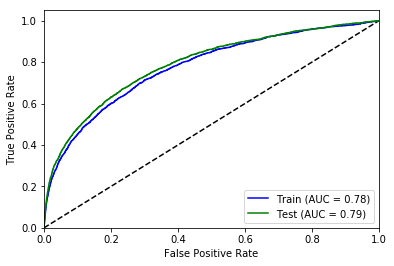

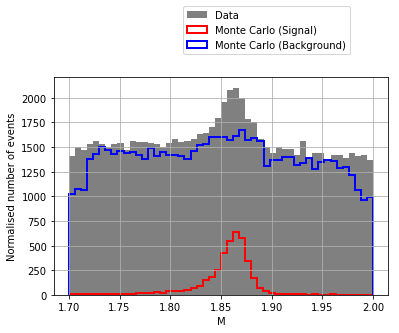

'Signal To Noise before 12.79 and after 14.93'

In [206]:
sideband_bdt = XGBoostWrapper(ntrees=20)
sideband_bdt.fit(sideband_X, sideband_y, sideband_weights)
evaluate_classifier(sideband_bdt)

The training seemed to work, but our signal-to-noise did not improve.
Unfortunately the optimisation code of scipy fails to optimize the signal-to-noise ratio here.
Hence we have to do it by hand.

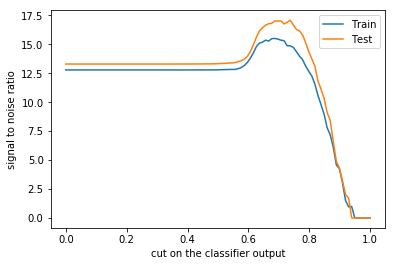

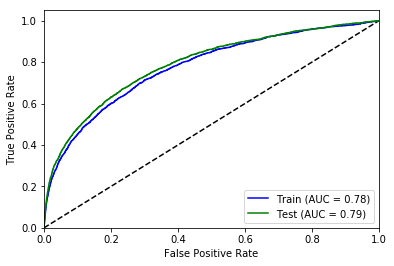

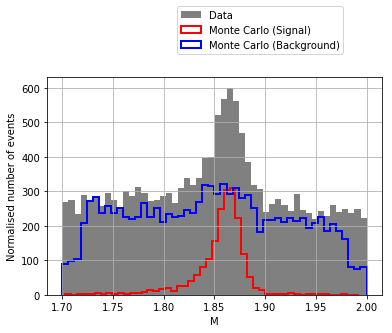

'Signal To Noise before 12.79 and after 15.43'

In [213]:
plot_fom(sideband_bdt)
evaluate_classifier(sideband_bdt, cut=0.7)

## Congratulation: You trained a classifier on data

You probably noticed that using our tools got much harder as soon as we did something more advanced.
This is often the case, therefore it is important to be aware of these pitfalls.
If something breaks in your application check for:
  - Are there any NaN values or infinity values present?
  - Do you violate any assumptions of your algorithm (positive weights, feature must be uncorrelated)?
  - Is your data somehow corrupted (wrong type or shape of the inputs)? (Aside: I once searched for two days why tensorflow was not working correctly just to discover that it accepts 1d arrays in place of 2d arrays but corrupts the data while doing so...).
  
Hint: If the above example didn't work for you, your probably violated one of the assumptions of Sideband Subtraction. In this case read the instructions above more carefully.

# Hyper-Parameter Optimization

So far you tuned the hyper-parameters of the algorithms by hand.
Of course you can (and should) automatize this. There are several approaches.
At first we investigate the most commonly used.

## Grid Search

Grid Search is a very simple hyper-parameter optimization algorithm.
It just tries out all possible combinations of hyper-parameters and reports the best configuration.
You only require a figure of merit which you want to optimize. Here we use the area under the receiver operating characteristic curve (AUC ROC)

GridSearch is often combined with **CrossValidation**. As you know you need an independent test sample to estimate the performance of your classifier. In fact you need to split your trainin dataset **again** into a so called training and validation sample. If you have limited statistics this can be a problem!

GridSearch with CrossValidation solves this by partioning your training dataset into 3 (or more generally N) equal parts. It fits your classifier three times using
 - Set 1 and 2 to fit and 3 to test
 - Set 1 and 3 to fit and 2 to test
 - Set 2 and 3 to fit and 1 to test
This has the advantage that you can use the whole training dataset to estimate the performance, but you can still train on 2/3 of the data. If you choose N larger than 3 this gets even better (more data is used for each training, while the final estimation is still based on the whole dataset).

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.2min finished


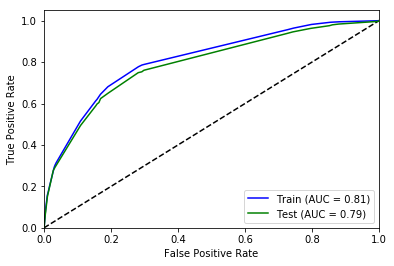

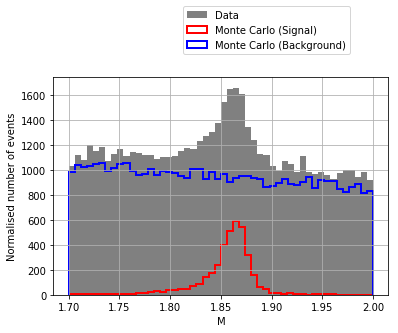

'Signal To Noise before 12.80 and after 17.71'

In [215]:
import sklearn.model_selection
gs = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(),
                                          param_grid={'max_depth': [2,5,7,10],
                                                      'criterion': ['gini', 'entropy']},
                                          scoring='roc_auc', verbose=1)
gs.fit(train[features], train[target].values.ravel())
evaluate_classifier(gs)

## Exercise 5

5.1 Perform a grid search for the BDT, parallelise the training to speed it up. Use the following hyper parameters: n_estimators, max_depth, and subsampling.

## Bayesian Optimization

Next we optimize our hyper-parameters with Bayesian Optimization (BO) using scikit-optimize. BO builds a statistical model of your figure of merit (fom) as a function of your hyper-parameters. The model is usually based on gaussian processes. Using this model the algorithm can predict the point in the hyper-parameter space which has the highest probability to improve your fom.

skopt does (as far as I know) not have a builtin cross validation. therefore we have to split the training dataset ourselves! Don't use your test dataset for this, because otherwise you over-fit the hyper-parameters to your test data (yes this is possible!).

[5, 2]
[1, 53]
[18, 75]
[15, 77]
[13, 57]
[11, 99]
[5, 40]
[5, 33]
[16, 94]
[2, 44]
[17, 8]
[4, 46]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44de4360f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f44df450ef0>]], dtype=object)

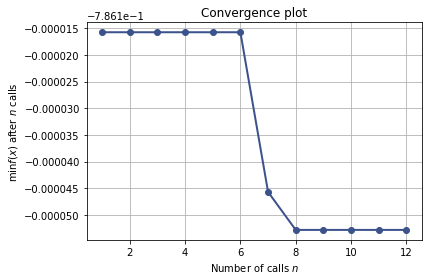

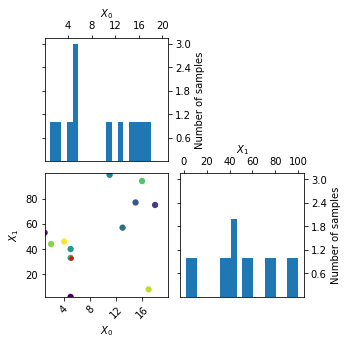

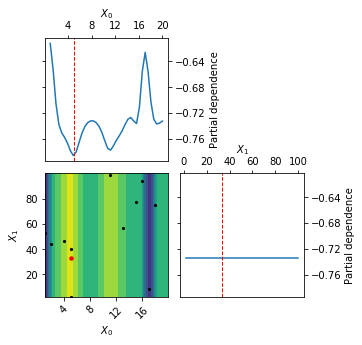

In [229]:
import skopt

bo_train, bo_test = train[:len(train)//2], train[len(train)//2:]

def fom(x):
    " Figure of merit which is minimized by skopt "
    print(x)
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=int(x[0]), min_samples_split=int(x[1]))
    clf.fit(bo_train[features], bo_train[target].values.ravel())
    p = clf.predict_proba(bo_test[features])[:, 1]
    return - sklearn.metrics.roc_auc_score(bo_test[target], p, sample_weight=bo_test['w'])

res = skopt.gp_minimize(fom, [(1, 20), (2, 100)], x0=[5, 2], n_calls=12)
skopt.plots.plot_convergence(res)
skopt.plots.plot_evaluations(res)
skopt.plots.plot_objective(res)

## Exercise 6

6.1 Interpret the plots provided by skopt.

6.2 Perform a BO for the BDT. Use the following hyper parameters: n_estimators, max_depth, and subsampling.